## This notebook contains the process up to training the model. It also includes converting the Keras model to ONNX.

# Import the necessary libraries

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score
import numpy as np

# Load the CIFAR-10 dataset

In [ ]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to [0, 1] range by dividing by 255
X_train, X_test = X_train / 255.0, X_test / 255.0

# Print the shapes of the datasets to verify
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing labels shape: (10000, 1)


# ResNet-18 architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to [0, 1] range by dividing by 255
X_train, X_test = X_train / 255.0, X_test / 255.0

# Build ResNet-18 model
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution Layer
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Residual Block function with skip connection
    def residual_block(x, filters):
        skip = x
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)  # Batch normalization
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)  # Batch normalization

        # If the dimensions change, use a 1x1 convolution to match the skip connection
        if skip.shape[-1] != filters:
            skip = layers.Conv2D(filters, (1, 1), padding='same')(skip)

        x = layers.add([x, skip])  # Skip connection
        x = layers.ReLU()(x)
        return x

    # ResNet-18 architecture: 2 blocks of 64 filters, 2 blocks of 128 filters, 2 blocks of 256 filters, 2 blocks of 512 filters
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and compile the model
model = build_resnet18()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()





Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 16, 16, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 16, 16, 64)     │              0 │ batch_normalization_3… │
│                           │                        │                │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 16, 16, 64)     │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ re_lu_1[0][0]          │
├──────────────────────

 Total params: 11,246,346 (42.90 MB)

 Trainable params: 11,238,666 (42.87 MB)

 Non-trainable params: 7,680 (30.00 KB)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# Plot training accuracy and loss

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 172s 182ms/step - accuracy: 0.3762 - loss: 1.6955 - val_accuracy: 0.4409 - val_loss: 1.6581
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 168s 159ms/step - accuracy: 0.6089 - loss: 1.0883 - val_accuracy: 0.6382 - val_loss: 1.0232
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 159ms/step - accuracy: 0.6840 - loss: 0.8891 - val_accuracy: 0.5924 - val_loss: 1.1879
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 162ms/step - accuracy: 0.7367 - loss: 0.7563 - val_accuracy: 0.6322 - val_loss: 1.0724
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 159ms/step - accuracy: 0.7692 - loss: 0.6595 - val_accuracy: 0.5580 - val_loss: 1.3911
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 161ms/step - accuracy: 0.7996 - loss: 0.5806 - val_accuracy: 0.7284 - val_loss: 0.7907
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 158ms/step - accuracy: 0.8185 - loss: 0.5206 - val_accuracy: 0.7537 - val_loss: 0.7517
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 158ms/step - accuracy: 0.8427 -

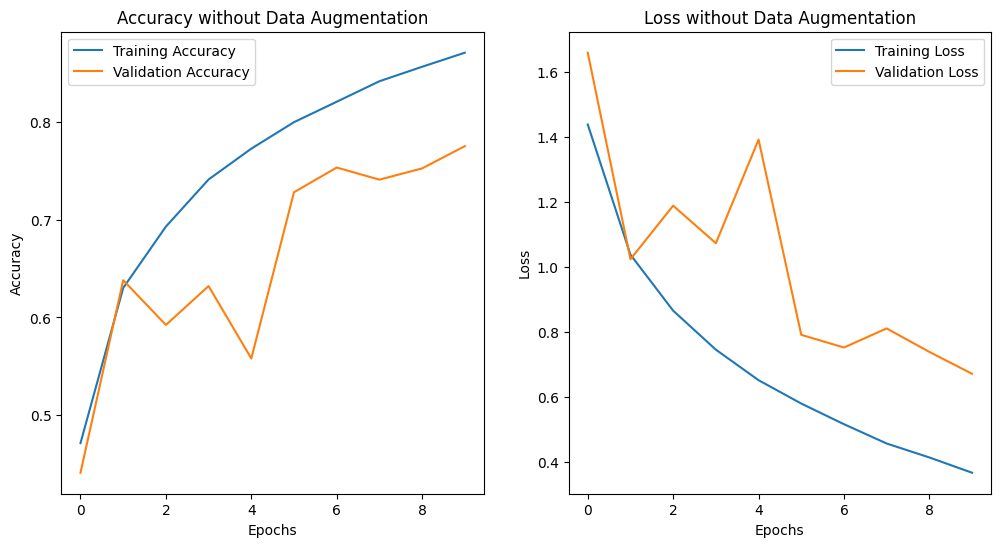

In [ ]:
history_no_augmentation = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Plot training accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_no_augmentation.history['accuracy'], label='Training Accuracy')
plt.plot(history_no_augmentation.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy without Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_no_augmentation.history['loss'], label='Training Loss')
plt.plot(history_no_augmentation.history['val_loss'], label='Validation Loss')
plt.title('Loss without Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# F1-score without data augmentation

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report (F1-score)
print("Classification Report (Without Data Augmentation):")
print(classification_report(y_test, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
Classification Report (Without Data Augmentation):
              precision    recall  f1-score   support

           0       0.68      0.89      0.77      1000
           1       0.92      0.90      0.91      1000
           2       0.86      0.63      0.73      1000
           3       0.57      0.78      0.66      1000
           4       0.93      0.60      0.73      1000
           5       0.80      0.67      0.73      1000
           6       0.87      0.77      0.82      1000
           7       0.83      0.82      0.83      1000
           8       0.81      0.93      0.87      1000
           9       0.83      0.93      0.88      1000

    accuracy                           0.79     10000
   macro avg       0.81      0.79      0.79     10000
weighted avg       0.81      0.79      0.79     10000



# Data Augmentation and Hyperparameter

In [ ]:
# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Instantiate and compile the model with hyperparameter tuning (e.g., adjusted learning rate)
model = build_resnet18()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Adjusted learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with data augmentation
history_with_augmentation = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                                      epochs=50,
                                      validation_data=(X_test, y_test))




Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 154s 173ms/step - accuracy: 0.4009 - loss: 1.6567 - val_accuracy: 0.4596 - val_loss: 1.6514
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 185s 160ms/step - accuracy: 0.5961 - loss: 1.1226 - val_accuracy: 0.5941 - val_loss: 1.2339
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 127s 162ms/step - accuracy: 0.6677 - loss: 0.9393 - val_accuracy: 0.6247 - val_loss: 1.1569
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 160ms/step - accuracy: 0.7121 - loss: 0.8205 - val_accuracy: 0.7146 - val_loss: 0.8554
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 161ms/step - accuracy: 0.7460 - loss: 0.7268 - val_accuracy: 0.6744 - val_loss: 1.0357
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 159ms/step - accuracy: 0.7738 - loss: 0.6536 - val_accuracy: 0.7596 - val_loss: 0.7325
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 161ms/step - accuracy: 0.7955 - loss: 0.6017 - val_accuracy: 0.7110 - val_loss: 0.9442
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 125s 159ms/step - accuracy: 0.8086 - loss: 0.55

# F1-score with data augmentation

In [ ]:
y_pred_aug = model.predict(X_test)
y_pred_aug_classes = np.argmax(y_pred_aug, axis=1)

# Classification Report (F1-score)
print("Classification Report (With Data Augmentation):")
print(classification_report(y_test, y_pred_aug_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
Classification Report (With Data Augmentation):
              precision    recall  f1-score   support

           0       0.85      0.93      0.88      1000
           1       0.95      0.93      0.94      1000
           2       0.93      0.74      0.83      1000
           3       0.84      0.72      0.77      1000
           4       0.88      0.90      0.89      1000
           5       0.85      0.78      0.82      1000
           6       0.92      0.92      0.92      1000
           7       0.85      0.95      0.90      1000
           8       0.93      0.93      0.93      1000
           9       0.80      0.97      0.88      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
from sklearn.metrics import classification_report, f1_score

# Compute classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Compute overall F1-score (macro & weighted)
macro_f1 = f1_score(y_test, y_pred_classes, average='macro')
weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77      1000
           1       0.92      0.90      0.91      1000
           2       0.86      0.63      0.73      1000
           3       0.57      0.78      0.66      1000
           4       0.93      0.60      0.73      1000
           5       0.80      0.67      0.73      1000
           6       0.87      0.77      0.82      1000
           7       0.83      0.82      0.83      1000
           8       0.81      0.93      0.87      1000
           9       0.83      0.93      0.88      1000

    accuracy                           0.79     10000
   macro avg       0.81      0.79      0.79     10000
weighted avg       0.81      0.79      0.79     10000

Macro F1-score: 0.7911
Weighted F1-score: 0.7911


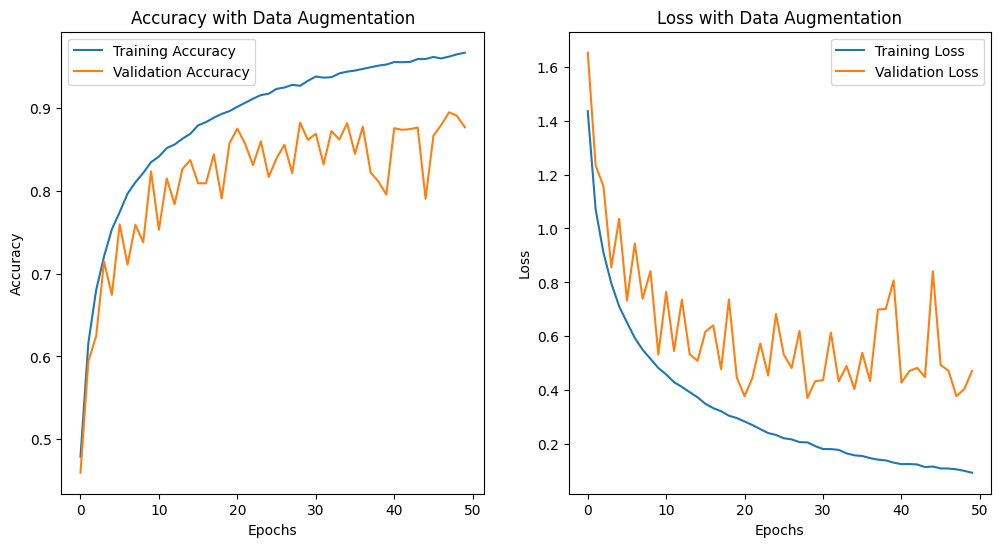

In [ ]:
# Plot training accuracy and loss with data augmentation
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_with_augmentation.history['accuracy'], label='Training Accuracy')
plt.plot(history_with_augmentation.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy with Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_with_augmentation.history['loss'], label='Training Loss')
plt.plot(history_with_augmentation.history['val_loss'], label='Validation Loss')
plt.title('Loss with Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model_path = "/content/drive/My Drive/resnet18_cifar10.h5"
model.save(model_path)
print(f"Model saved at: {model_path}")


Model saved at: /content/drive/My Drive/resnet18_cifar10.h5


In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/My Drive/resnet18_cifar10.h5"
model_tuned = load_model(model_path)
print("Model loaded successfully!")


Model loaded successfully!


# Average Latency per sample (Without TensorRT)

In [ ]:
import time
import numpy as np

# Select a single test image
sample_image = np.expand_dims(X_test[0], axis=0)  # Add batch dimension

# Measure inference time
num_runs = 100  # Run multiple times for accuracy
start_time = time.time()

for _ in range(num_runs):
    _ = model_tuned.predict(sample_image, verbose=0)

end_time = time.time()

# Compute average latency per sample
avg_latency = (end_time - start_time) / num_runs
print(f"Average Latency per sample (Without TensorRT): {avg_latency:.6f} seconds")


Average Latency per sample (Without TensorRT): 0.085235 seconds


# Model Testing

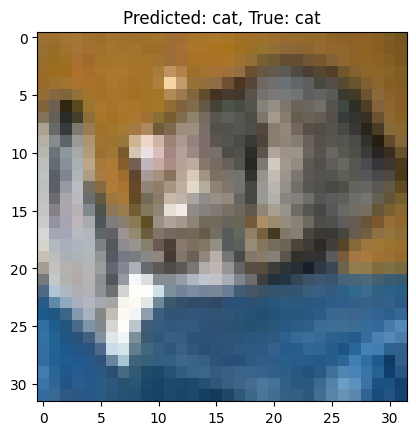

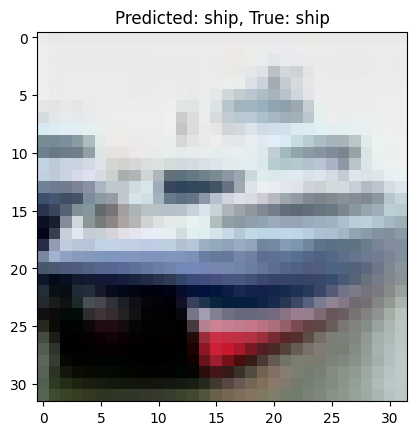

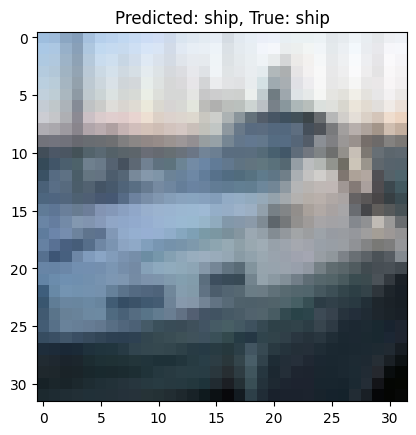

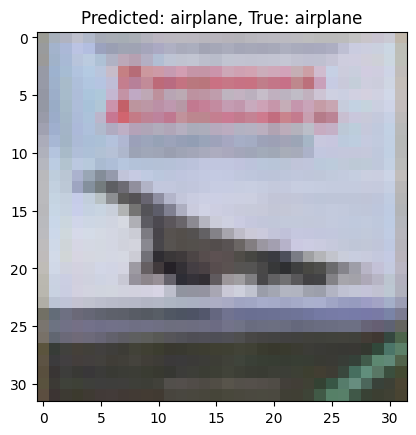

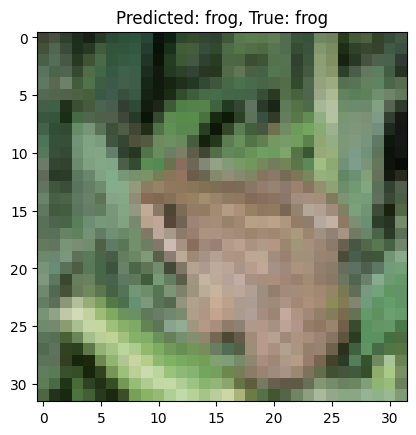

In [ ]:
import matplotlib.pyplot as plt

# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


for i in range(5):
    plt.imshow(X_test[i])
    plt.title(f"Predicted: {class_names[y_pred_classes[i]]}, True: {class_names[y_test[i][0]]}")
    plt.show()


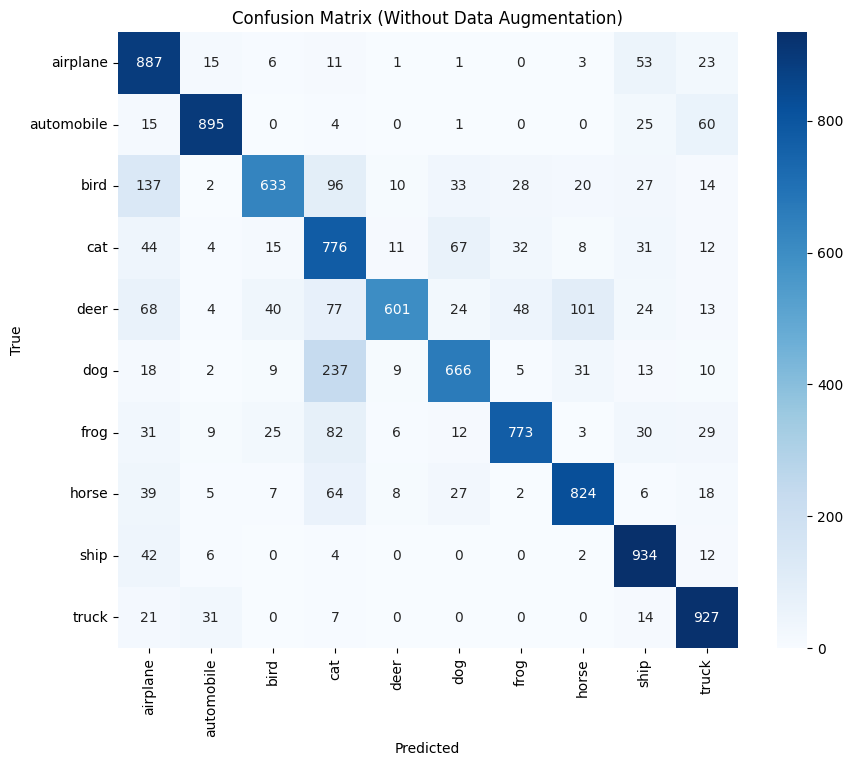

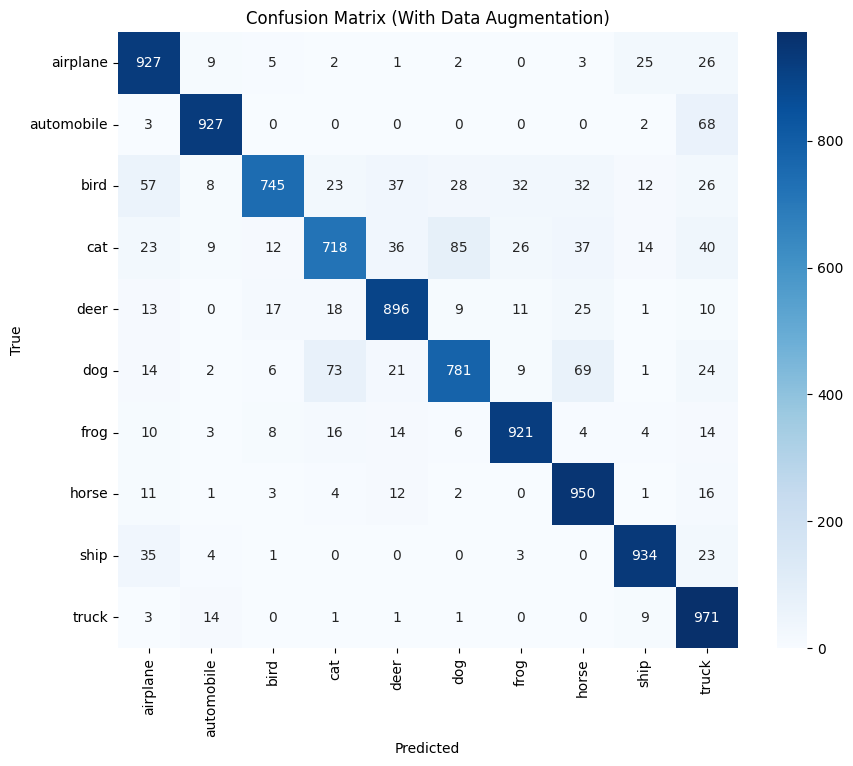

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix


# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Without Data Augmentation)')
plt.show()


# Compute the confusion matrix for the augmented model
conf_matrix_aug = confusion_matrix(y_test, y_pred_aug_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (With Data Augmentation)')
plt.show()

Convert the Model to ONNX

In [ ]:
!pip install --upgrade tf2onnx onnx

In [ ]:
import tensorflow as tf

# Load the model
model_path = "/content/drive/MyDrive/resnet18_cifar10.h5"
model = tf.keras.models.load_model(model_path)

# Save the model in SavedModel format
saved_model_path = "/content/drive/MyDrive/resnet18_saved_model"
tf.saved_model.save(model, saved_model_path)

print(f"Model saved in SavedModel format at: {saved_model_path}")


Model saved in SavedModel format at: /content/drive/MyDrive/resnet18_saved_model


In [ ]:
!python -m tf2onnx.convert --saved-model /content/drive/MyDrive/resnet18_saved_model --output /content/drive/MyDrive/cifar10_resnet18.onnx --opset 13


E0000 00:00:1738143464.273741    5807 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738143464.287290    5807 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-01-29 09:37:49,035 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2025-01-29 09:37:49,037 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2025-01-29 09:37:51,038 - INFO - Signatures found in model: [serving_default].
2025-01-29 09:37:51,038 - WARNING - '--signature_def' not specified, using first signature:

In [ ]:

import onnx
onnx_model = onnx.load("/content/drive/MyDrive/cifar10_resnet18.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid.")

ONNX model is valid.


Converting .onnx model to .trt for Inference using TensorRT